<>:24: SyntaxWarning: invalid escape sequence '\('
<>:24: SyntaxWarning: invalid escape sequence '\('
/tmp/ipython-input-3985676682.py:24: SyntaxWarning: invalid escape sequence '\('
  mask = ~df.columns.str.contains("src|\(\d+\)|Unnamed|placeholder|image|carousel", regex=True, case=False)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 45.8 MB/s eta 0:00:00
Done. Matches found: 25


,Amazon_idx,Noon_idx,Amazon_Product,Amazon_Price,Noon_Product,Noon_Price,Match_Score,Price_Difference,Best_Option
0,5,17,"NIVEA MEN Antiperspirant Roll-on for Men, DEEP...",77.00,Nivea Men Deep Black Carbon Dark Wood Antipers...,79.0,100.000000,-2.00,Amazon
1,7,36,Axe Body Spray for Men Recharge 150ML,139.00,Axe Body Spray for Men Recharge 150ml,165.0,100.000000,-26.00,Amazon
2,6,46,Axe Body Spray for Men Ice Chill 150ML,139.00,Axe Body Spray for Men Ice Chill 150ml,174.0,100.000000,-35.00,Amazon
3,37,9,Dermactive Sweat Control Intense Roll-On 60Ml,106.20,Dermactive Sweat Control Intense Roll-On,169.0,100.000000,-62.80,Amazon
4,44,18,Axe Body Spray for Men Black 150ML,143.00,Axe Body Spray for Men Black Night 150ml,166.0,100.000000,-23.00,Amazon
5,34,25,Dove Women Antiperspirant Deodorant Roll On Po...,86.95,Dove Dove Women Antiperspirant Deodorant Roll ...,89.0,100.000000,-2.05,Amazon
6,23,24,Axe Body Spray for Men Dark Temptation 150ML,149.00,Axe Axe Body Spray for Men Dark Temptation Cle...,166.0,100.000000,-17.00,Amazon
7,16,0,Starville roll on whitening light pink free 60 ml,105.00,starville Roll On Whitening 60 ML,110.0,100.000000,-5.00,Amazon
8,14,18,Axe Body Spray for Men Black Night 150ML,155.00,Axe Body Spray for Men Black Night 150ml,166.0,100.000000,-11.00,Amazon
9,36,49,Nivea Invisible Black & White Deodorant Spray ...,124.96,Nivea Black And White Invisible Antiperspirant...,140.0,100.000000,-15.04,Amazon


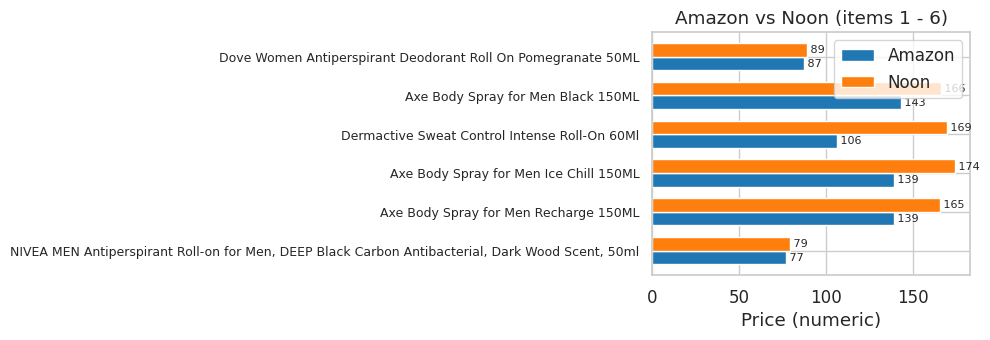

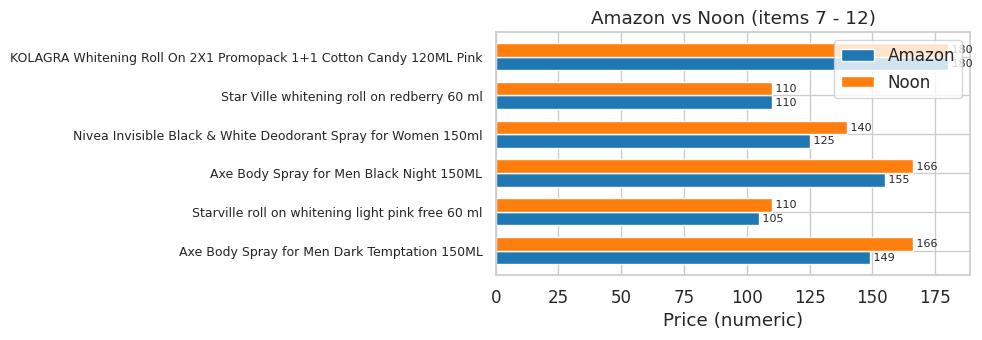

/tmp/ipython-input-3985676682.py:169: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


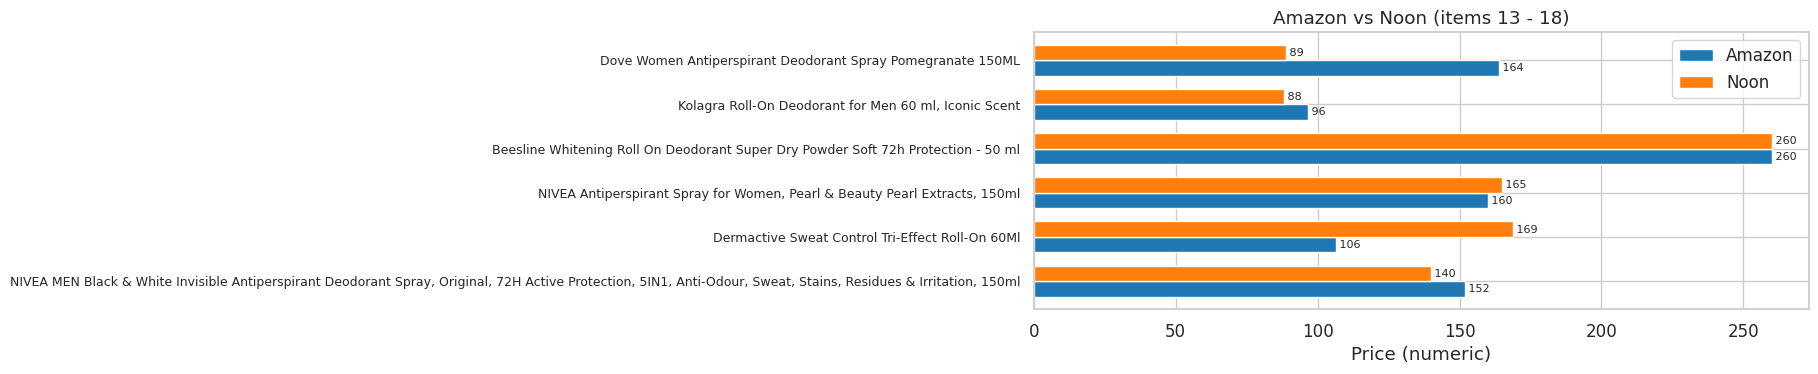

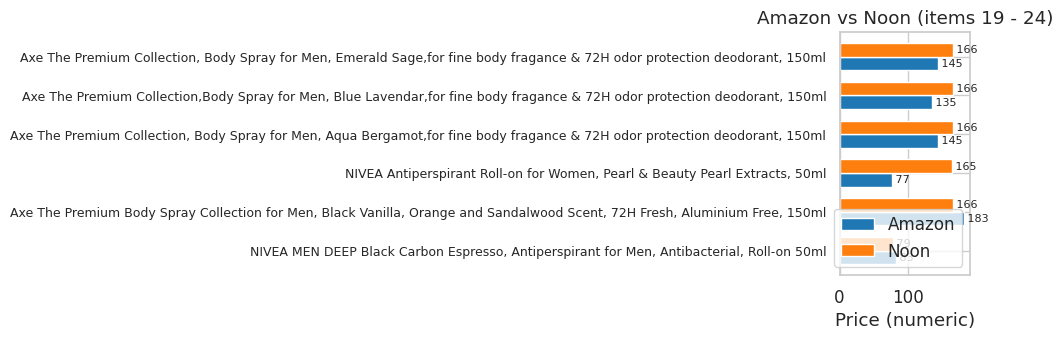

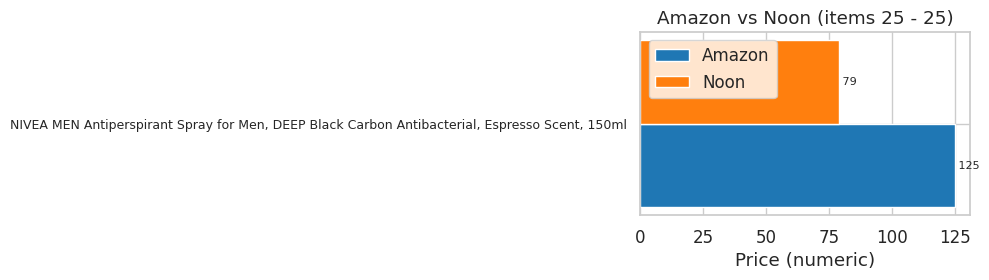

Saved: amazon_cleaned_snapshot.csv, noon_cleaned_snapshot.csv, Amazon_vs_Noon_comparison.csv/xlsx


In [1]:
!pip install rapidfuzz --quiet

import pandas as pd, numpy as np, re
from rapidfuzz import process, fuzz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", font_scale=1.1)

# تحديث أسماء الملفات لتتناسب مع ملفاتك
AMAZON_FILE = "amazon_Deodorants_&_Antiperspirants.xlsx"
NOON_FILE   = "noon_Deodorants_&_Antiperspirants.csv"
MATCH_THRESHOLD = 85
BATCH_SIZE = 6

# قراءة الملفات
amazon = pd.read_excel(AMAZON_FILE)
noon   = pd.read_csv(NOON_FILE)

# حفظ نسخة احتياطية
amazon.to_csv("amazon_backup_before_clean.csv", index=False)
noon.to_csv("noon_backup_before_clean.csv", index=False)

def drop_junk_cols(df):
    mask = ~df.columns.str.contains("src|\(\d+\)|Unnamed|placeholder|image|carousel", regex=True, case=False)
    return df.loc[:, mask]

def find_column_like(df, patterns):
    cols = df.columns.tolist()
    for p in patterns:
        for c in cols:
            if p.lower() in c.lower():
                return c
    text_cols = [c for c in cols if df[c].dtype == object]
    if text_cols:
        avg_len = {c: df[c].astype(str).map(len).mean() for c in text_cols}
        best = max(avg_len, key=avg_len.get)
        return best
    return None

def clean_numeric_series(s):
    s = s.astype(str).str.replace(",", "", regex=False).str.strip()
    extracted = s.str.extract(r"([0-9]+(?:\.[0-9]+)?)")[0]
    return pd.to_numeric(extracted, errors="coerce")

def normalize_product_name(s):
    s = str(s).lower()
    s = re.sub(r"package(ing)? may vary", " ", s)
    s = re.sub(r"\b(\d+\s*(ml|g|gm|kg|l|oz|cm|mm))\b", " ", s)
    s = re.sub(r"\b(ml|g|gm|kg|l|oz|pack|packs|pcs|piece|pieces|box|set)\b", " ", s)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# تنظيف الأعمدة غير الضرورية
amazon = drop_junk_cols(amazon)
noon = drop_junk_cols(noon)

# تحديد الأعمدة في بيانات الأمازون (بناءً على هيكل ملفك)
a_product_col = "Product_Name"  # اسم العمود الموجود في ملف الأمازون
a_price_col = "Price"           # اسم عمود السعر في ملف الأمازون
a_rating_col = "Rating"         # اسم عمود التقييم في ملف الأمازون
a_reviews_col = "Reviews"       # اسم عمود المراجعات في ملف الأمازون

# تحديد الأعمدة في بيانات نون (بناءً على هيكل ملفك)
n_product_col = "Product_Name"  # اسم العمود الموجود في ملف نون
n_price_col = "Price"           # اسم عمود السعر في ملف نون
n_rating_col = "Rating"         # اسم عمود التقييم في ملف نون
n_reviews_col = "Reviews"       # اسم عمود المراجعات في ملف نون

# تنظيف بيانات الأمازون
amazon_clean = pd.DataFrame()
amazon_clean['Product_raw'] = amazon[a_product_col]
amazon_clean['Price_raw'] = amazon[a_price_col]
amazon_clean['Rating_raw'] = amazon[a_rating_col]
amazon_clean['Reviews_raw'] = amazon[a_reviews_col]

# تنظيف بيانات نون
noon_clean = pd.DataFrame()
noon_clean['Product_raw'] = noon[n_product_col]
noon_clean['Price_raw'] = noon[n_price_col]
noon_clean['Rating_raw'] = noon[n_rating_col]
noon_clean['Reviews_raw'] = noon[n_reviews_col]

# تطبيع أسماء المنتجات
amazon_clean['Product_norm'] = amazon_clean['Product_raw'].fillna("").map(normalize_product_name)
noon_clean['Product_norm'] = noon_clean['Product_raw'].fillna("").map(normalize_product_name)

# تنظيف البيانات الرقمية
amazon_clean['Price'] = clean_numeric_series(amazon_clean['Price_raw'])
amazon_clean['Rating'] = clean_numeric_series(amazon_clean['Rating_raw'])
amazon_clean['Reviews'] = clean_numeric_series(amazon_clean['Reviews_raw'])

noon_clean['Price'] = clean_numeric_series(noon_clean['Price_raw'])
noon_clean['Rating'] = clean_numeric_series(noon_clean['Rating_raw'])
noon_clean['Reviews'] = clean_numeric_series(noon_clean['Reviews_raw'])

# حفظ البيانات المنظفة
amazon_clean.to_csv("amazon_cleaned_snapshot.csv", index=False)
noon_clean.to_csv("noon_cleaned_snapshot.csv", index=False)

# المقارنة بين المنتجات
noon_choices = noon_clean['Product_norm'].fillna("").tolist()
results = []
for idx, row in amazon_clean.iterrows():
    a_name = row['Product_norm']
    if not a_name.strip():
        continue
    match = process.extractOne(a_name, noon_choices, scorer=fuzz.token_set_ratio)
    if match is None:
        continue
    best_name, score, match_index = match
    if score < MATCH_THRESHOLD:
        continue
    n_row = noon_clean.iloc[match_index]
    a_price = row['Price'] if not pd.isna(row['Price']) else np.nan
    n_price = n_row['Price'] if not pd.isna(n_row['Price']) else np.nan
    price_diff = (a_price - n_price) if (not np.isnan(a_price) and not np.isnan(n_price)) else np.nan
    if np.isnan(price_diff):
        if not np.isnan(a_price) and np.isnan(n_price):
            best_opt = "Amazon"
        elif np.isnan(a_price) and not np.isnan(n_price):
            best_opt = "Noon"
        else:
            best_opt = "Unknown"
    else:
        best_opt = "Amazon" if a_price < n_price else "Noon"

    results.append({
        "Amazon_idx": idx,
        "Noon_idx": match_index,
        "Amazon_Product": row['Product_raw'],
        "Amazon_Price": a_price,
        "Noon_Product": n_row['Product_raw'],
        "Noon_Price": n_price,
        "Match_Score": score,
        "Price_Difference": price_diff,
        "Best_Option": best_opt
    })

comparison = pd.DataFrame(results).sort_values("Match_Score", ascending=False).reset_index(drop=True)
comparison.to_csv("Amazon_vs_Noon_comparison.csv", index=False)
comparison.to_excel("Amazon_vs_Noon_comparison.xlsx", index=False)

print("Done. Matches found:", len(comparison))
display(comparison.head(30))

def plot_batches(df, batch_size=6, amazon_col="Amazon_Price", noon_col="Noon_Price"):
    names = df["Amazon_Product"].astype(str).tolist()
    a_prices = df[amazon_col].tolist()
    n_prices = df[noon_col].tolist()
    for i in range(0, len(names), batch_size):
        batch_names = names[i:i+batch_size]
        batch_a = a_prices[i:i+batch_size]
        batch_n = n_prices[i:i+batch_size]
        y = np.arange(len(batch_names))
        height = 0.35
        plt.figure(figsize=(10, max(3, len(batch_names)*0.6)))
        plt.barh(y - height/2, batch_a, height=height, label="Amazon", color="#1f77b4")
        plt.barh(y + height/2, batch_n, height=height, label="Noon", color="#ff7f0e")
        plt.yticks(y, batch_names, fontsize=9)
        plt.xlabel("Price (numeric)")
        plt.title(f"Amazon vs Noon (items {i+1} - {i+len(batch_names)})")
        for yi, av, nv in zip(y, batch_a, batch_n):
            if not pd.isna(av):
                plt.text(av, yi - height/2, f" {av:.0f}", va="center", fontsize=8)
            if not pd.isna(nv):
                plt.text(nv, yi + height/2, f" {nv:.0f}", va="center", fontsize=8)
        plt.legend()
        plt.tight_layout()
        plt.show()

if not comparison.empty:
    plot_df = comparison.sort_values("Match_Score", ascending=False).reset_index(drop=True)
    plot_batches(plot_df, batch_size=BATCH_SIZE)

print("Saved: amazon_cleaned_snapshot.csv, noon_cleaned_snapshot.csv, Amazon_vs_Noon_comparison.csv/xlsx")